Sentiment analysis is the automated interpretation and classification of emotions (usually positive, negative, or neutral) from textual data such as written reviews and social media posts. 

Businesses can use insights from sentiment analysis to improve their products, fine-tune marketing messages, correct misconceptions, and identify positive influencers. Sentiment analysis of social media, emails, support tickets, chats, product reviews, and recommendations have become a valuable resource used in almost all industry verticals. It’s very helpful in helping businesses to gain insights, understand customers, predict and enhance the customer experience, tailor marketing campaigns, and aid in decision-making.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import tensorflow
# import tensorflow.keras.layers.experimental.preprocessing.Normalization
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

%matplotlib inline

import os
print(os.listdir("input"))

['test.ft.txt.bz2', 'train.ft.txt.bz2']


In [10]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        # Bzip2 is an open source algorithm for compression and decompression of files. 
        # Python’s bz2 module provides the functionality to implement the bzip2 algorithm programmatically.
        x = line.decode("utf-8")
        # UTF-8 stands for “Unicode Transformation Format - 8 bits.”  
        # It is used as a better way to encode all possible characters with one system. It is an encoding system that solves the space issue of ASCII. 
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
        # The .strip() method removes any leading (spaces at the beginning) and trailing (spaces at the end) characters (space is the default leading character to remove).
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('input/train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('input/test.ft.txt.bz2')


In [11]:
train_labels.shape

(3600000,)

In [12]:
type(test_texts)

list

In [13]:
train_texts

['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'Amazing!: This soundtrack is my favorite music of all

In [14]:
train_labels

array([1, 1, 1, ..., 0, 0, 1])

In [15]:
test_labels.shape

(400000,)

In [16]:
test_labels

array([1, 1, 0, ..., 0, 1, 0])

In [17]:
train = pd.DataFrame(train_texts, columns = ['DATA_COLUMN'])
test =  pd.DataFrame(test_texts, columns = ['DATA_COLUMN'])

In [18]:
train["LABEL_COLUMN"] = train_labels
test["LABEL_COLUMN"] = test_labels

In [19]:
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [20]:
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1


In [21]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)


In [24]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, random_state=7302022, test_size=0.2)
# Here I selected 20% of the whole data as the test dataset, following the 80/20 rule.

In [39]:
train_texts

['   don t overlook the fact that the package includes only one side of the cable   you need to buy two packages for left right ',
 'a brilliant fairy tale thriller  bill willingham s  fables  is hands down my favorite comic book being published today  the first volume in the series was a great mystery  and i urge you to read that before reading any further  since it s impossible to review this book without running the risk of spoiling the outcome   this time out he takes the turn of a political thriller  snow white and company visit the fables farm  upstate  where the non human refugees from fairy tales and folklore live  she finds herself caught in an uprising  fomented by enraged pigs  shades of george orwell here  and backed by a surprising ally while  legends in exile  was a wonderful inaugural story for  fables   it is here that the series really begins to hit its stride  the artwork is beautiful and the story is imaginative and sharp  this is a series that will take its place ne

In [25]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)


In [41]:
train_texts

[[64,
  21,
  7549,
  1,
  344,
  12,
  1,
  820,
  1330,
  60,
  26,
  405,
  7,
  1,
  695,
  13,
  188,
  5,
  83,
  127,
  5144,
  11,
  390,
  185],
 [4,
  1022,
  3349,
  1120,
  1766,
  1464,
  17,
  9,
  789,
  164,
  23,
  297,
  1948,
  20,
  193,
  1214,
  489,
  1,
  76,
  739,
  10,
  1,
  209,
  14,
  4,
  31,
  857,
  3,
  2,
  4782,
  13,
  5,
  52,
  12,
  156,
  150,
  97,
  1270,
  187,
  6,
  17,
  953,
  5,
  258,
  8,
  20,
  215,
  824,
  1,
  2333,
  7,
  1,
  5103,
  8,
  58,
  42,
  59,
  425,
  1,
  482,
  7,
  4,
  1433,
  1766,
  2571,
  568,
  3,
  458,
  2351,
  1,
  3942,
  195,
  1,
  610,
  841,
  38,
  3349,
  2284,
  3,
  11687,
  310,
  88,
  1889,
  1461,
  1577,
  10,
  44,
  57,
  7683,
  6376,
  7,
  1417,
  11991,
  191,
  3,
  5599,
  57,
  4,
  2968,
  158,
  4989,
  10,
  11664,
  14,
  4,
  260,
  107,
  11,
  6,
  9,
  191,
  12,
  1,
  209,
  65,
  2389,
  5,
  667,
  124,
  11577,
  1,
  3306,
  9,
  365,
  3,
  1,
  107,
  9,
  4464,
  

In [42]:
test_texts

[[31,
  91,
  23,
  1516,
  4273,
  47,
  26,
  7,
  1,
  31,
  1904,
  7,
  79,
  1939,
  2,
  22,
  1029,
  5,
  8,
  91,
  11,
  140,
  3,
  2,
  129,
  81,
  6,
  53,
  2,
  104,
  10,
  4,
  34,
  2053,
  6,
  211,
  46,
  231,
  93,
  4,
  130,
  2053,
  37,
  35,
  2293,
  10,
  1,
  2248,
  8,
  91,
  37,
  155,
  1027,
  25,
  3,
  644,
  37,
  1517,
  26,
  7,
  155,
  17,
  2443,
  4204,
  8,
  9,
  4,
  3854,
  91,
  10,
  23,
  20,
  180,
  88,
  125,
  131,
  6,
  222,
  9,
  37,
  861,
  46,
  2699,
  2,
  237,
  8,
  55,
  616,
  427,
  568,
  456,
  137,
  1767,
  1340,
  2081,
  500,
  26,
  162,
  72,
  14,
  12,
  908],
 [26,
  7,
  1,
  89,
  147,
  121,
  6525,
  11,
  4,
  147,
  2,
  144,
  21,
  65,
  237,
  1043,
  1,
  344,
  12,
  2,
  22,
  60,
  524,
  4,
  249,
  2639,
  7,
  1,
  147,
  1,
  121,
  2,
  316,
  618,
  1,
  1325,
  5,
  4827,
  92,
  14,
  31,
  24,
  68,
  1703,
  46,
  5,
  279,
  1,
  1018,
  3,
  6,
  2537,
  26,
  7,
  23,
  297,
  56

In [26]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
# The max() function returns the item with the highest value in an iterable.
# Here, the variable 'MAX_LENGTH' returns the longest text in the training dataset.
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)


In [44]:
test_texts

array([[   0,    0,    0, ...,   14,   12,  908],
       [   0,    0,    0, ...,  368,  163,    6],
       [   0,    0,    0, ...,   93, 3787,  432],
       ...,
       [   0,    0,    0, ..., 1584,   11,  441],
       [   0,    0,    0, ..., 3077,    5,   52],
       [   0,    0,    0, ...,    5,  203, 1337]])

In [43]:
def build_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
   
    x = layers.Conv1D(64, 3, activation='relu')(embedded)
  
    #x = layers.BatchNormalization()(x)
  
    x = layers.MaxPool1D(3)(x)
  
    x = layers.Conv1D(64, 5, activation='relu')(x)
    #x = layers.BatchNormalization()(x)
 
    x = layers.MaxPool1D(5)(x)
    # Here, x
    x = layers.Conv1D(64, 5, activation='relu')(x)
    # Here, x
    x = layers.GlobalMaxPool1D()(x)
  
    x = layers.Flatten()(x)

    x = layers.Dense(100, activation='relu')(x)

    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
 
        metrics=['binary_accuracy']
 
    )
    return model
model = build_model()




In [44]:
model.fit(
    train_texts, 
    train_labels, 
    batch_size=1000,
    epochs=2,
    # Why 1?
    validation_data=(val_texts, val_labels), )


Epoch 1/2
2880/2880 [==============================] - 966s 335ms/step - loss: 0.1902 - binary_accuracy: 0.9248 - val_loss: 0.1697 - val_binary_accuracy: 0.9349
Epoch 2/2
2880/2880 [==============================] - 1308s 454ms/step - loss: 0.1456 - binary_accuracy: 0.9457 - val_loss: 0.1422 - val_binary_accuracy: 0.9468


In [45]:
from keras.models import load_model
model.save('2epochmodel.h5')

## Model Accuracy 

In [27]:
from tensorflow.keras.models import load_model
model = load_model("model.h5")

In [46]:
preds = model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('AUC-ROC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))


Accuracy score: 0.9467
F1 score: 0.946
AUC-ROC score: 0.9871


In [30]:
type(preds)

numpy.ndarray

In [ ]:
type(test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, preds)

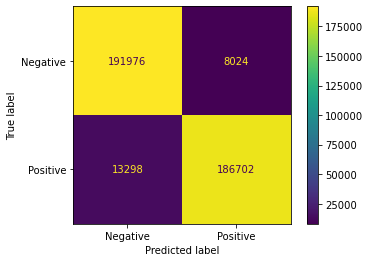

In [49]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_labels, 1*(preds>0.5))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Positive"])

cm_display.plot()
plt.show()

<AxesSubplot:>

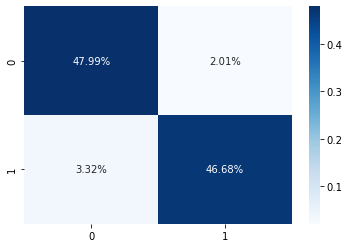

In [50]:
import seaborn as sns
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')

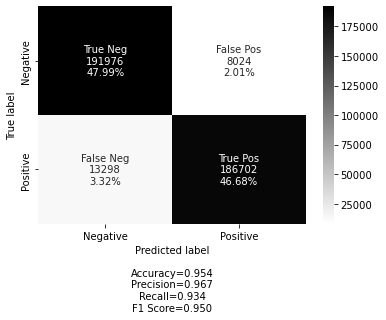

In [58]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Negative', 'Positive']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [57]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
#         accuracy  = np.trace(cf) / float(np.sum(cf))
        accuracy  = 0.954

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
#             precision = cf[1,1] / sum(cf[:,1])
#             recall    = cf[1,1] / sum(cf[1,:])
            precision = 0.967
            recall = 0.934
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={}\nPrecision={}\nRecall={}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)